# Tarea 2, pregunta 3: "Encoder-Decoder sobre Texto"

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

In [14]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Modificar estilos de jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

# Tamaño fuente matplotlib
font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

In [15]:
# Se importa el dataset
import pandas as pd
df = pd.read_csv("dataset_3/spa.txt", sep="\t", names=["Source","Target"])
display(df.head())
df.shape

,Source,Target
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


(123376, 2)

## a)
Visualice los datos ¿Qué es la entrada y qué es la salida? Comente sobre los múltiples significados/sinónimos que puede tener una palabra al ser traducida y cómo propondría arreglar eso. *se espera que pueda implementarlo*

In [16]:
display(df.tail())

,Source,Target
123371,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
123372,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
123373,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...
123374,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe..."
123375,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...


## b)
Realice un pre-procesamiento a los textos como se acostumbra para eliminar símbolos inecesarios u otras cosas que estime conveniente, comente sobre la importancia de éste paso. Además de ésto deberá agregar un símbolo al final de la sentencia *target* para indicar un "alto" cuando la red neuronal necesite aprender a generar una sentencia.

In [17]:
import string
table = str.maketrans('', '', string.punctuation) 
def clean_text(text, where=None):
    """ OJO: Sin eliminar el significado de las palabras."""
    text = text.lower()
    tokenize_text = text.split()
    tokenize_text = [word.translate(table) for word in tokenize_text]#eliminar puntuacion
    tokenize_text = [word for word in tokenize_text if word.isalpha()] #remove numbers
    if where =="target":
        tokenize_text = tokenize_text + ["#end"] 
    return tokenize_text
texts_input = list(df['Source'].apply(clean_text))
texts_output = list(df['Target'].apply(clean_text, where='target'))

In [18]:
from sklearn.model_selection import train_test_split
X_train_l, X_test_l, Y_train_l, Y_test_l = train_test_split(texts_input, texts_output,
                                                            test_size=5000, random_state=22)
X_train_l, X_val_l, Y_train_l, Y_val_l = train_test_split(X_train_l, Y_train_l, 
                                                          test_size=5000, random_state=22)


idx = np.random.choice(np.arange(len(X_train_l)), 15000, replace=False)
X_train_l = np.asarray(X_train_l)[idx]
Y_train_l = np.asarray(Y_train_l)[idx]

## c)
Genere un vocabulario, **desde el conjunto de entrenamiento**, sobre las palabras a recibir y generar en la traducción, esto es codificarlas a un valor entero que servirá para que la red las vea en una representación útil a procesar, *comience desde el 1 debido a que el cero será utilizado más adelante*. Para reducir el vocabulario considere las palabras que aparecen un mínimo de *min_count* veces en todo los datos, se aconseja un valor de 3. Comente sobre la importancia de ésto al reducir el vocabulario ¿De qué tamaño es el vocabulario de entrada y salida? ¿La diferencia de ésto podría ser un factor importante?

In [19]:
def create_vocab(texts, min_count=1):
    count_vocab = {}
    for sentence in texts:
        for word in sentence:
            if word not in count_vocab:
                count_vocab[word] = 1
            else:
                count_vocab[word] += 1
    return [word for word,count in count_vocab.items() if count >= min_count]

vocab_source = create_vocab(X_train_l, min_count=4)
word2idx_s = {w: i+1 for i, w in enumerate(vocab_source)} #index (i+1) start from 1,2,3,...
idx2word_s = {i+1: w for i, w in enumerate(vocab_source)}
n_words_s = len(vocab_source)
vocab_target = create_vocab(Y_train_l, min_count=3)
word2idx_t = {w: i+1 for i, w in enumerate(vocab_target)}  #Converting text to numbers
idx2word_t = {i+1 : w for i, w in enumerate(vocab_target)}
n_words_t = len(vocab_target)

Ahora codifique las palabras a los números indexados con el vocabulario. Recuerde que si una palabra en los otros conjuntos, o en el mismo de entrenamiento, no aparece en el vocabulario no se podrá generar una codificación, por lo que será **ignorada** ¿Cómo se podría evitar ésto?

In [20]:
""" Source/input data """

def convert_text_to_index(X, vocabulary):
    transformed_data = list()
    for sentence in X:
        words_in_vocabulary = True
        trasnformed_sentence = []
        for word in sentence:
            if word in vocabulary:
                trasnformed_sentence.append(vocabulary[word])
            else:
                words_in_vocabulary = False
                break
        if words_in_vocabulary:
            transformed_data.append(trasnformed_sentence)
            
    return transformed_data
            
dataX_train = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_train_l]
dataX_val = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_val_l]
dataX_test = [[word2idx_s[word] for word in sent if word in word2idx_s] for sent in X_test_l]


# dataX_train_2 = convert_text_to_index(X_train_l, word2idx_s)
# dataX_valid_2 = convert_text_to_index(X_val_l, word2idx_s)
# dataX_test_2 = convert_text_to_index(X_test_l, word2idx_s)
""" Target/output data """
dataY_train = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_train_l]
dataY_val = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_val_l] 
dataY_test = [[word2idx_t[word] for word in sent if word in word2idx_t] for sent in Y_test_l] 

Se podría evitar generando el vocabulario a partir de TODO el dataset antes de particionarlo en los distintos conjuntos de entrenamiento, validación y testing. Así se debería disminuir la posibilidad de que una palabra no se encuentre presente en el vocabulario. Otra cosa que se podría hacer es disminuir la cantidad mínima de ocurrencias de una palabra para que esta sea conciderada en el vocabulario, actualmente está puesto en 3.

## d)
Debido al largo variable de los textos de entrada y salida será necesario estandarizar ésto para poder trabajar de manera más cómoda en Keras, *cada texto (entrada y salida) pueden tener distinto largo máximo*. Comente sobre la decisión del tipo de *padding*, *pre o post* ¿Qué sucede al variar el largo máximo de instantes de tiempo para procesar en cada parte del modelo (entrada y salida)?

In [21]:
from keras.preprocessing import sequence
""" INPUT DATA (Origin language) """
max_inp_length = max(map(len, dataX_train)) # Se saca el largo de la sentencia más larga
print("Largo max inp: ", max_inp_length)
word2idx_s["PAD"] = 0 #padding symbol
idx2word_s[0] = "PAD"
n_words_s += 1  

# Se procede a aplicar el padding
X_train = sequence.pad_sequences(dataX_train, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_val = sequence.pad_sequences(dataX_val, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])
X_test = sequence.pad_sequences(dataX_test, maxlen=max_inp_length, padding='pre', value=word2idx_s["PAD"])

""" OUTPUT DATA (Destination language) """
max_out_length = max(map(len,dataY_train)) 
print("Largo max out: ",max_out_length)
word2idx_t["PAD"] = 0 #padding symbol
idx2word_t[0] = "PAD"
n_words_t += 1  
Y_train = sequence.pad_sequences(dataY_train, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_val = sequence.pad_sequences(dataY_val, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])
Y_test = sequence.pad_sequences(dataY_test, maxlen=max_out_length, padding='post', value=word2idx_t["PAD"])

Largo max inp:  29
Largo max out:  29


## e)
Para evitar que la red obtenga una ganancia por imitar/predecir el símbolo de *padding* que está bastante presente en los datos coloque un peso sobre éste clase, con valor 0, así se evita que tenga impacto en la función objetivo. Ya que *keras* no soporta directamente ésto en series de tiempo coloque el peso a cada instante de tiempo de cada dato de entrenamiento dependiendo de su clase. Comente sobre alguna otra forma en que se podría manejar el evitar que la red prediga en mayoría el símbolo de *padding*.

In [22]:
c_weights = np.ones(n_words_t)
c_weights[0] = 0 #padding class masked
sample_weight = np.zeros(Y_train.shape)
for i in range(sample_weight.shape[0]):
    sample_weight[i] = c_weights[Y_train[i,:]]

In [23]:
from keras.utils import to_categorical
Y_train = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_train])
Y_val = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_val])
Y_test = np.asarray([to_categorical(i, num_classes=n_words_t) for i in Y_test])

## f)
Para lograr la tarea defina una red recurrente del tipo *encoder*-*decoder* como la que se presenta en la siguiente imágen.
<img src="https://chunml.github.io/ChunML.github.io/images/projects/sequence-to-sequence/repeated_vector.png" width="60%" />
En primer lugar defina el *Encoder* que procesara el texto de entrada y retornará un solo vector final, haciendo uso de las capas ya conocidas de *Embedding* para generar un vector denso de palabra y *GRU*, pero en su versión acelerada para GPU.

Luego defina la sección que conecta el largo (*timesteps*) de entrada *vs* el de salida.

Finalmente defina el *Decoder* para generar la secuencia de salida en texto de palabras en otro idioma, a través de la función *softmax* sobre cada instante de tiempo (*timestep*). 

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, TimeDistributed, Dense, Dropout
EMBEDDING_DIM = 100
model_F = Sequential()
model_F.add(Embedding(input_dim=n_words_s, output_dim=EMBEDDING_DIM, input_length=max_inp_length))
model_F.add(CuDNNGRU(64, return_sequences=True))
model_F.add(CuDNNGRU(128, return_sequences=False))

from keras.layers import RepeatVector
model_F.add(RepeatVector(max_out_length)) #conection

# Decoder
model_F.add(CuDNNGRU(128, return_sequences=True))
model_F.add(CuDNNGRU(64, return_sequences=True))
model_F.add(TimeDistributed(Dense(n_words_t, activation='softmax')))
model_F.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 29, 100)           193300    
_________________________________________________________________
cu_dnngru_17 (CuDNNGRU)      (None, 29, 64)            31872     
_________________________________________________________________
cu_dnngru_18 (CuDNNGRU)      (None, 128)               74496     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 29, 128)           0         
_________________________________________________________________
cu_dnngru_19 (CuDNNGRU)      (None, 29, 128)           99072     
_________________________________________________________________
cu_dnngru_20 (CuDNNGRU)      (None, 29, 64)            37248     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 29, 2983)          193895    
Total para

In [34]:
print(max_out_length)
print(Y_train.shape)
print(Y_val.shape)

29
(15000, 29, 2983)
(5000, 29, 2983)


Entrene la red entre 1 a 5 *epochs*, agregando los pesos definidos sobre cada ejemplo de entrenamiento. Además de utilizar una función de pérdida que evita generar explícitamente los *one hot vector*

In [41]:
# model_F.compile(optimizer='adam', loss='sparse_categorical_crossentropy', sample_weight_mode='temporal')
# history_F = model_F.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_val, Y_val), sample_weight = sample_weight, verbose=1)

model_F.compile(optimizer='adam', loss='categorical_crossentropy')
history_F = model_F.fit(X_train, Y_train, epochs=3, batch_size=256,validation_data=(X_val, Y_val), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 5000 samples
Epoch 1/3
15000/15000 [==============================] - 37s 2ms/step - loss: 4.4995 - val_loss: 1.9161
Epoch 2/3
15000/15000 [==============================] - 14s 913us/step - loss: 1.7261 - val_loss: 1.5369
Epoch 3/3
15000/15000 [==============================] - 13s 894us/step - loss: 1.5236 - val_loss: 1.4308


/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


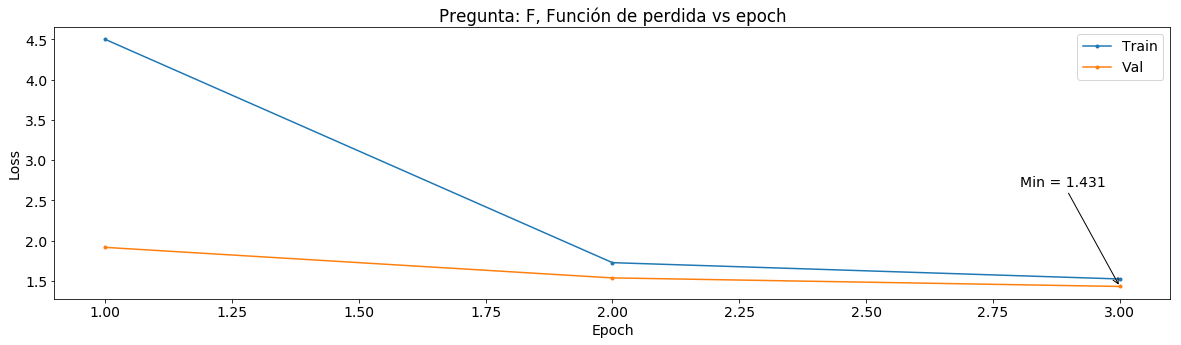

In [42]:
def chart_loss(history, epoch_number, question):
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val') )
    plt.title("Pregunta: {}, Función de perdida vs epoch".format(question))

    max_index = np.argmin(history.history['val_loss'])
    max_value = history.history['val_loss'][max_index].round(3)
    plt.annotate('Min = {}'.format(max_value), xy=(max_index+1, max_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

chart_loss(history_F, 3, "F")